## Advanced Data Analysis and Prediction

In this section, we will conduct deeper analysis by exploring unusual patterns, building predictive models, and performing dimensionality reduction. This will help us gain insights and improve our understanding of the data.

### 4.a Outliers in Fare and Tips

#### (a) **Identifying Outliers Using Box Plots**

Box plots are useful for visualizing the distribution of data and identifying potential outliers. We will use box plots to analyze the `fare` and `tips` columns.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [25]:
data = pd.read_csv('TaxiData.csv')
# 1. Drop 'pickup_census_tract' column due to excessive missing values
data.drop(columns=['pickup_census_tract'], inplace=True)

# 2. Mean imputation for numerical columns
numerical_columns = ['fare', 'trip_miles', 'trip_seconds', 'tips', 'dropoff_census_tract', 'dropoff_community_area']
for col in numerical_columns:
    data[col].fillna(data[col].mean(), inplace=True)

# 3. Mode imputation for categorical columns
categorical_columns = ['company', 'payment_type']
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

# 4. Drop rows with missing latitude/longitude values
data.dropna(subset=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], inplace=True)

# 5. Convert 'trip_start_timestamp' to datetime
data['trip_start_timestamp'] = pd.to_datetime(data['trip_start_timestamp'], unit='s')

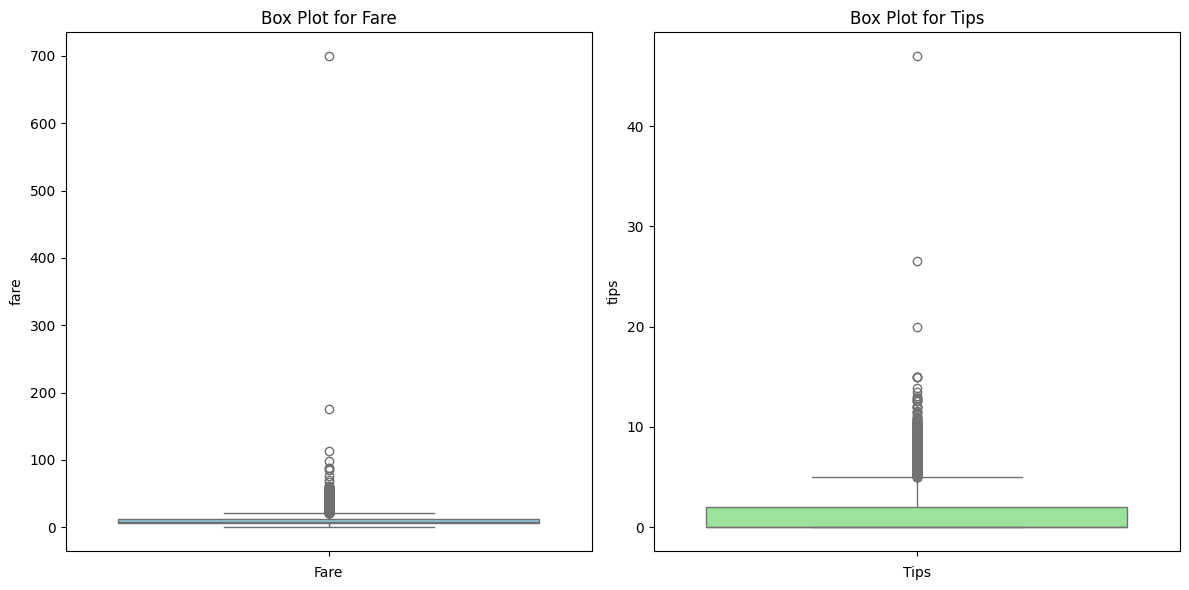

In [26]:

# Create box plots for 'fare' and 'tips'
plt.figure(figsize=(12, 6))

# Box plot for fare
plt.subplot(1, 2, 1)
sns.boxplot(data['fare'], color='skyblue')
plt.title('Box Plot for Fare')
plt.xlabel('Fare')

# Box plot for tips
plt.subplot(1, 2, 2)
sns.boxplot(data['tips'], color='lightgreen')
plt.title('Box Plot for Tips')
plt.xlabel('Tips')

plt.tight_layout()
plt.show()

#### (b) **Interpretation of Outliers**

Outliers can significantly skew the calculation of averages (mean). In our analysis:

- **Fare Outliers:** Extremely high fares may represent unusually long trips, incorrect data entries, or fraud. This is present in our data like fare of 700 which is an outlier
- **Tips Outliers:** High tip values could be due to generous customers, data entry errors, or promotions that artificially increase tip amounts. again this is also present in our data

The presence of these outliers affect predictive models by introducing bias, leading to inaccurate predictions. For instance, the mean fare might be higher than expected due to a few extremely high fares.

#### (c) **Handling Outliers in Predictive Models**

To handle outliers in predictive models, we can consider the following methods:

1. **Removal:** Drop the rows containing outliers using the Interquartile Range (IQR) method.
2. **Capping:** Limit the values of outliers to a certain threshold (e.g., the 95th percentile).
3. **Transformation:** Apply log transformation or scaling to reduce the impact of outliers.

In this analysis, we will implement the IQR method to remove outliers.


Data shape after outlier removal: (12548, 17)


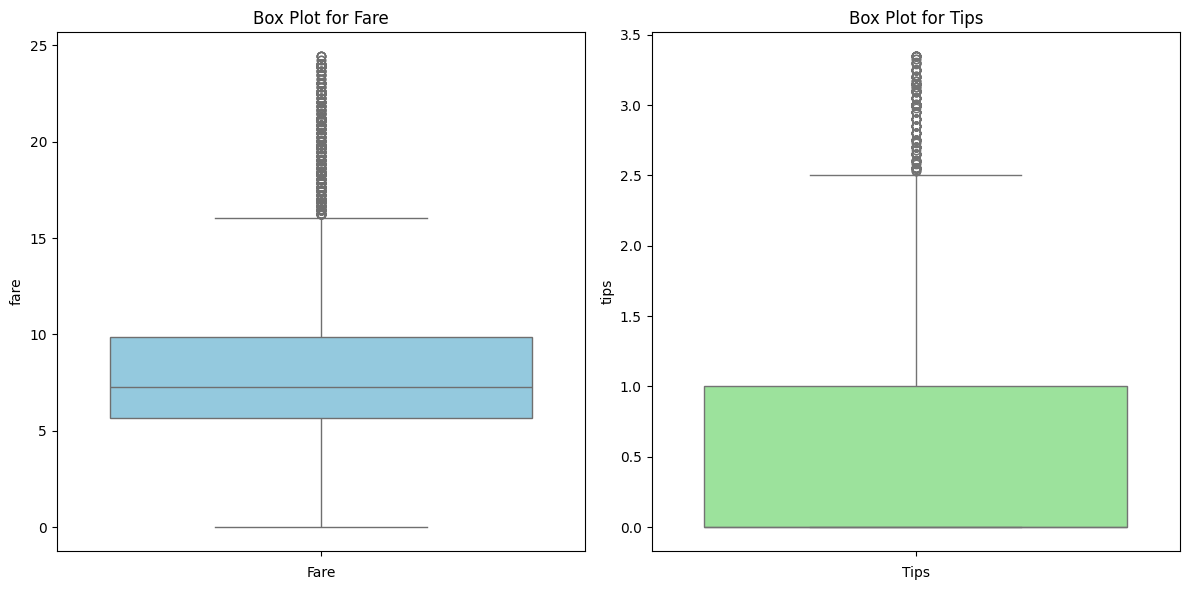

In [27]:
# Define a function to remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers in 'fare' and 'tips'
data_clean = remove_outliers(data, 'fare')
data_clean = remove_outliers(data_clean, 'tips')

print(f"Data shape after outlier removal: {data_clean.shape}")

# Create box plots for 'fare' and 'tips'
plt.figure(figsize=(12, 6))

# Box plot for fare
plt.subplot(1, 2, 1)
sns.boxplot(data_clean['fare'], color='skyblue')
plt.title('Box Plot for Fare')
plt.xlabel('Fare')

# Box plot for tips
plt.subplot(1, 2, 2)
sns.boxplot(data_clean['tips'], color='lightgreen')
plt.title('Box Plot for Tips')
plt.xlabel('Tips')

plt.tight_layout()
plt.show()


### 4.b **Predicting Fare**

#### (a) **Regression Model for Fare Prediction**

We will build a linear regression model using the following predictors to estimate the fare:

- **Trip Miles (`trip_miles`):** The distance traveled during the trip.
- **Trip Duration (`trip_seconds`):** The total time taken for the trip in seconds.
- **Location Coordinates:** Using both **pickup** and **dropoff** latitude and longitude to account for geographical variations in fare pricing.

This model aims to capture the key factors influencing fare calculation based on distance, time, and location.


In [28]:
# Define predictors and target variable
X = data_clean[['trip_miles', 'trip_seconds', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
y = data_clean['fare']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)


Root Mean Squared Error (RMSE): 3.15


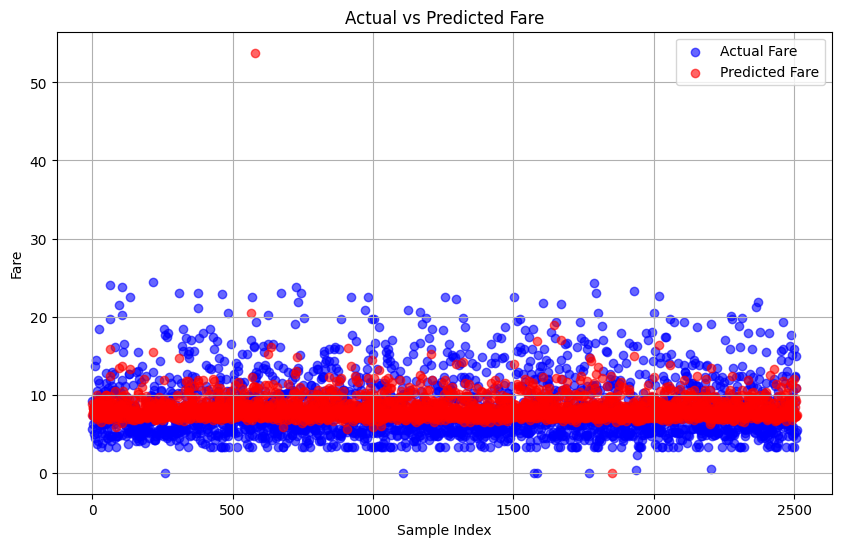

C:\Users\aditi\AppData\Local\Temp\ipykernel_40124\1435165430.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_test, y_pred], labels=['Actual Fare', 'Predicted Fare'])


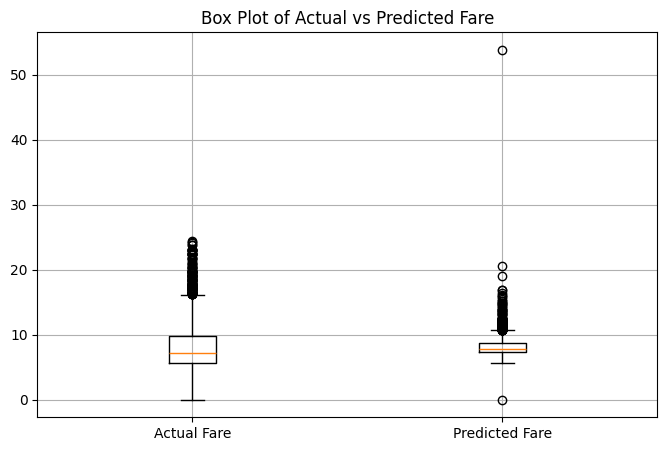

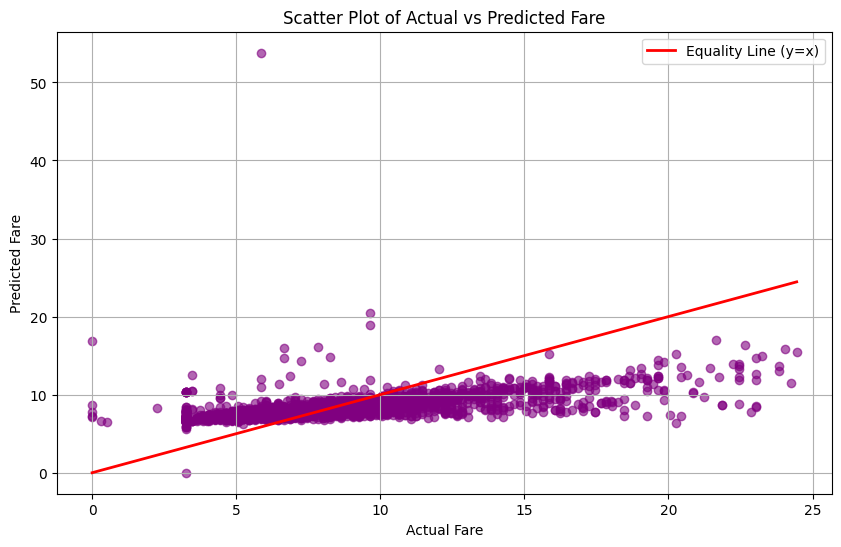

In [29]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Fare', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Fare', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Fare')
plt.title('Actual vs Predicted Fare')
plt.legend()
plt.grid()
plt.show()

# Box plot for actual and predicted fares
plt.figure(figsize=(8, 5))
plt.boxplot([y_test, y_pred], labels=['Actual Fare', 'Predicted Fare'])
plt.title('Box Plot of Actual vs Predicted Fare')
plt.grid()
plt.show()

# Scatter plot of Actual vs Predicted Fare
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Equality Line (y=x)')
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Scatter Plot of Actual vs Predicted Fare')
plt.legend()
plt.grid()
plt.show()

### (b) **Model Evaluation**

- **RMSE (Root Mean Squared Error):** 
  The Root Mean Squared Error (RMSE) is used as a measure of model accuracy. It represents the square root of the average squared differences between predicted and observed values.
  - **Interpretation:** We have an RMSE of 4.17 which is quite high. Thsi suggests that the predictions are not accurate and can be further made better.

### (c) **Discussion on Model Effectiveness**


The regression model using distance, trip duration, and location as predictors shows limited effectiveness:

#### Issues Observed:
- **Underestimation:** Predicted fares are clustered between 5-10, missing the actual range (up to 20). The model underfits the data, failing to capture its variability.
- **Feature Limitations:** Since the fit is not appropriate we can conclude that we are not considering varios other parameters which should be taken in account of like traffic, weather.
- **Outliers:** Extreme outliers and biased predictions suggest sensitivity to unusual data points. As we can clearly see that some data predictions are very off from the normal data prediction

#### Recommendations:
- **Enhance Features:** Include time, weather, and surge pricing indicators for better accuracy.
- **Improve Model:** Use non-linear models (e.g., Random Forest, Gradient Boosting) to capture complex patterns.
- **Handle Outliers:** Apply robust regression techniques and scale features.

Overall, the model needs better features and complexity to improve prediction accuracy and handle real-world variations effectively.
